## Training of GAiA's neural network

In [1]:
from model.GAiA_network import GAiA_Network, coeff_determination
from lib.dataset_utils import read_many_hdf5, board_shape

import pickle
import tensorflow as tf
import matplotlib.pyplot as plt

import platform
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

if tf.test.gpu_device_name(): 
  print(f"Default GPU Device: {tf.test.gpu_device_name()}")

Default GPU Device: /device:GPU:0


2022-01-12 00:50:05.891893: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 00:50:06.049358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 00:50:06.159483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 00:50:06.159664: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

We load our training dataset.

In [2]:
directory = "/media/gaetan/HDD/IA/Chess/Datasets/SE_ResNet/"
positions_train, scores_train = read_many_hdf5(1389333, directory, "_train")
positions_valid, scores_valid = read_many_hdf5(19849, directory, "_validation")

We retrieve the model's optimal hyperparameters from the `choose_hyperparameters` notebook.

In [3]:
input_file = open("model/hyperparameters.pickle", "rb")
hyperparams = pickle.load(input_file)
input_file.close()
print(hyperparams)

{'nb_blocks': 4, 'filters': 64}


We create a model with these hyperparameters.

In [4]:
model = GAiA_Network(board_shape, hyperparams)
model.compile(loss="mean_absolute_error", optimizer="adam", metrics=[coeff_determination])
model.summary()

Model: "GAiA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 8, 8, 15)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 8, 8, 64)     1024        ['input[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 8, 8, 64)    256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     4160        ['batch_normalization[0][0]'] 

2022-01-11 20:12:02.160472: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:12:02.160742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:12:02.160943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:12:02.161349: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-11 20:12:02.161776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

It's time to train! You can take a coffee or two (maybe more).

In [5]:
valid_data = (positions_valid, scores_valid)
nb_epochs = 60
history = model.fit(positions_train, scores_train, validation_data=valid_data, verbose=1, epochs=nb_epochs, batch_size=1024)

2022-01-11 20:12:02.454869: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5335038720 exceeds 10% of free system memory.
2022-01-11 20:12:05.545495: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5335038720 exceeds 10% of free system memory.


Epoch 1/60


2022-01-11 20:12:09.974139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


1357/1357 [==============================] - 35s 24ms/step - loss: 317.0996 - coeff_determination: 0.4034 - val_loss: 215.8225 - val_coeff_determination: 0.6115
Epoch 2/60
1357/1357 [==============================] - 32s 24ms/step - loss: 255.2379 - coeff_determination: 0.5311 - val_loss: 394.3698 - val_coeff_determination: 0.1828
Epoch 3/60
1357/1357 [==============================] - 32s 23ms/step - loss: 224.0176 - coeff_determination: 0.6893 - val_loss: 613.6008 - val_coeff_determination: -0.5653
Epoch 4/60
1357/1357 [==============================] - 32s 23ms/step - loss: 189.1844 - coeff_determination: 0.8416 - val_loss: 191.6759 - val_coeff_determination: 0.7386
Epoch 5/60
1357/1357 [==============================] - 32s 24ms/step - loss: 169.8745 - coeff_determination: 0.8953 - val_loss: 415.4188 - val_coeff_determination: -0.1790
Epoch 6/60
1357/1357 [==============================] - 32s 24ms/step - loss: 166.3674 - coeff_determination: 0.8985 - val_loss: 396.5187 - val_coeff

We save the model.

In [6]:
model.save("model/GAiA_Network.h5")

/home/gaetan/.local/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


We convert the model to onnx format so that the engine can use it.

In [10]:
tf.saved_model.save(model, "model/GAiA_Network")
!python3.9 -m tf2onnx.convert --saved-model model/GAiA_Network --output ../Engine/build/network.onnx

INFO:tensorflow:Assets written to: model/GAiA_Network/assets
/usr/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-01-11 21:00:21,915 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-01-11 21:00:24,120 - INFO - Signatures found in model: [serving_default].
2022-01-11 21:00:24,120 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-01-11 21:00:24,121 - INFO - Output names: ['output']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-01-11 21:00:24,436 - WARNING - From /home/gaetan/.local/lib/python3.9/site-packages/tf2onnx/tf_loader.py:706: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.gra

In [1]:
def plot_history(history, path=None):
  epochs = range(1, nb_epochs + 1)

  _, axs = plt.subplots(1, 2, figsize=(20, 5))
  loss = history.history["loss"]
  score = history.history["coeff_determination"]

  axs[0].plot(epochs, loss, "r-.")
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Mean Absolute Error")
  axs[0].set_title("Training loss")

  axs[1].plot(epochs, score, "g-.")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("$R^2$")
  axs[1].set_title("Training score")
  
  if path:
    plt.savefig(path)

We plot the loss and accuracy of each epoch.

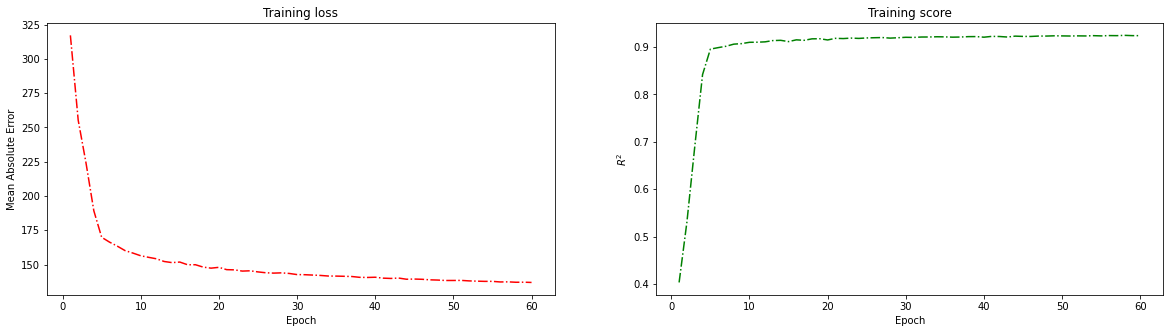

In [12]:
plot_history(history, path="results/GAiA_history")